# Sinkhorn divergence

Let $\mathrm{OT_\varepsilon}(\alpha, \beta)$ the entropic regularized OT distance between two distributions $\alpha$ and $\beta$. One issue with $\mathrm{OT_\varepsilon}$ is that $\mathrm{OT_\varepsilon}(\alpha, \alpha)$ is not necessarily equal to 0.

The Sinkhorn divergence, defined in [[Genevay et al.]](https://arxiv.org/abs/1706.00292) as $\mathrm{S}_\varepsilon(\alpha, \beta) = \mathrm{OT_\varepsilon}(\alpha, \beta) - \frac{1}{2}\mathrm{OT_\varepsilon}(\alpha, \alpha) - \frac{1}{2}\mathrm{OT_\varepsilon}(\beta, \beta)$ removes this entropic bias.

In this tutorial we showcase the advantage of removing the entropic bias using Gradient Flows on 2-D distributions, as done in [[Feydy et al.]](http://proceedings.mlr.press/v89/feydy19a/feydy19a.pdf).

## Imports

In [ ]:
from IPython import display

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ott
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

## Defining two distributions

Let us start by defining simple source and target distributions.

In [132]:
# Let us define a small distribution.
x = 0.5 * jax.random.normal(jax.random.PRNGKey(0), (25, 2))

# And a slightly bigger one.
y = jax.random.normal(jax.random.PRNGKey(1), (50, 2)) + jnp.array((6, 0))

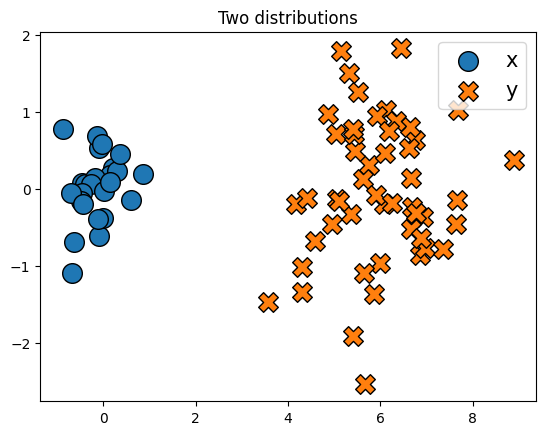

In [148]:
plt.title("Two distributions")
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

## Gradient flow with $\mathrm{OT}_\varepsilon$

Now we can compute the gradient flow for the regularized OT cost.

OTT returns quantities that are differentiable. In the following example, we leverage the gradients to move the points of $x$ in a way that minimizes the overall regularized OT cost. We start by defining a minimal optimization loop, that does fixed-length gradient descent, and records various ot objects along the way for plotting.

In [139]:
def optimize_reg_ot(
    x: jnp.ndarray,
    y: jnp.ndarray,
    num_iter: int = 300,
    learning_rate: float = 0.2,
    dump_every: int = 50,
    epsilon: float = 2.0,
):
    """Compute a gradient flow for the regularized OT cost."""

    ots = []

    # Wrapper function that returns OT cost and OT output given a geometry.
    def reg_ot_cost(geom):
        ot = Sinkhorn()(LinearProblem(geom))
        return ot.reg_ot_cost, ot

    # Apply jax.value_and_grad operator. Note that we make explicit that
    # we only wish to compute gradients w.r.t the first output,
    # using the has_aux flag. We also jit that function.
    reg_ot_cost_vg = jax.jit(jax.value_and_grad(reg_ot_cost, has_aux=True))

    # Run a naive, fixed stepsize, gradient descent on locations `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry.
        geom = PointCloud(x, y, epsilon=epsilon)

        # Compute the OT cost and its gradient.
        (reg_ot_cost, ot), geom_g = reg_ot_cost_vg(geom)

        # Assert that the solver converged.
        assert ot.converged

        # Perform a gradient descent step.
        x = x - geom_g.x * learning_rate

        # Save the current state of the optimization.
        if i % dump_every == 0:
            ots.append(ot)
    return ots

In [140]:
# Compute a gradient flow for the regularized OT cost.
ots = optimize_reg_ot(
    x, y, num_iter=500, learning_rate=0.2, epsilon=2, dump_every=50
)

As you can see, the distribution collapses to a thin strip. Let us fix this using the debiased quantity $\mathrm{S}_\varepsilon$.

In [141]:
# Display an animation of the optimization.
fig = plt.figure(figsize=(8, 5))
plott = ott.tools.plot.Plot(fig=fig, show_lines=False)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

## Gradient flow with $\mathrm{S}_\varepsilon$

By slightly adapting the previous function, we can compute the Gradient Flow using the Sinkhorn divergence instead of the regularized OT cost.

In [142]:
def optimize_sink_div(
    x: jnp.ndarray,
    y: jnp.ndarray,
    num_iter: int = 300,
    learning_rate: float = 0.2,
    dump_every: int = 50,
    epsilon: float = 2.0,
):
    """Compute a gradient flow for the Sinkhorn divergence."""

    ots = []

    # Wrapper function that returns OT cost and OT output given a geometry.
    def reg_ot_cost(geom):
        ot = ott.tools.sinkhorn_divergence.sinkhorn_divergence(
            geom, x=geom.x, y=geom.y
        )
        return ot.divergence, ot

    # Apply jax.value_and_grad operator. Note that we make explicit that
    # we only wish to compute gradients w.r.t the first output,
    # using the has_aux flag. We also jit that function.
    reg_ot_cost_vg = jax.jit(jax.value_and_grad(reg_ot_cost, has_aux=True))

    # Run a naive, fixed stepsize, gradient descent on locations `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry.
        geom = PointCloud(x, y, epsilon=epsilon)

        # Compute the OT cost and its gradient.
        (reg_ot_cost, ot), geom_g = reg_ot_cost_vg(geom)

        # Assert that the solver converged.
        assert ot.converged

        # Perform a gradient descent step.
        x = x - geom_g.x * learning_rate

        # Save the current state of the optimization.
        if i % dump_every == 0:
            ots.append(ot)
    return ots

In [143]:
# Compute a gradient flow for the Sinkhorn divergence.
ots = optimize_sink_div(
    x, y, num_iter=500, learning_rate=0.2, epsilon=2, dump_every=50
)

Thanks to the debiasing, the distributions overlap nicely.

In [144]:
# Here, we have to adapt the plotting object slightly to accomodate for the fact
# that we have Sinkhorn divergence outputs, which have a multiple geometries.
class CustomPlot(ott.tools.plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y


# Display an animation of the optimization.
fig = plt.figure(figsize=(8, 5))
plott = CustomPlot(fig=fig, show_lines=False)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()